# LAB 4. CONSTRAINED OPTIMIZATION: EQUALITY CONSTRAINTS

## 2. SEQUENTIAL QUADRATIC PROGRAMMING

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def plot_function_surface(func, x_1_range=(-2, 2), x_2_range=(-2, 2), n_samples=100):
    '''
    Function used to plot the surface of a 3D function.
    
    Generates both a 3D and a 2D plot of the surface of a 3D function by
    generating a 2D grid of points which will be evaluated using the given
    function.
    
    Paramteres
    ----------
        func: function (N,), (N,) -> (N,)
            Function to plotted. It is applied to each pair of values of
            the grid and returns a new value. 
        
        x_1_range: tuple of int, optional, default=(-2, 2)
            Tuple that specifies the range of the x_1 axis.
            
        x_2_range: tuple of int, optional, default=(-2, 2)
            Tuple that specifies the range of the x_2 axis.
        
        n_samples: int, optional, default=100
            Number of points that have to be generated in each axis.
    '''
    # Generate meshgrid and compute Z value
    x_1 = np.linspace(*x_1_range, n_samples)
    x_2 = np.linspace(*x_2_range, n_samples)
    X_1, X_2 = np.meshgrid(x_1, x_2)

    XY = np.c_[X_1.ravel(), X_2.ravel()]
    Z = np.apply_along_axis(func, 1, XY).reshape(X_1.shape)    
    # Clear current figure
    plt.clf()
    
    # Set figure size
    fig = plt.figure(figsize=(20, 8))
    
    # Create subplots
    ax1 = plt.subplot(121, projection='3d')
    ax2 = plt.subplot(122)    

    # Plot surface in axis 1
    surface = ax1.plot_surface(X_2, X_1, Z, cmap=cm.jet, rcount=100, ccount=100)
    
    # Plot contour and color bar which maps values to colors in axis 2
    ax2.contourf(X_2, X_1, Z, cmap=cm.jet)
    fig.colorbar(surface, shrink=0.5, aspect=5, ax=ax2)
    
    # Set labels
    ax1.set_xlabel(r'$x_2$')
    ax1.set_ylabel(r'$x_1$')
    ax1.set_zlabel(r'$f(x_1, x_2)$')
    
    ax2.set_xlabel(r'$x_2$')
    ax2.set_ylabel(r'$x_1$')    
    
    plt.show()

Let us define the functions that we will use to solve the problem:

In [3]:
def f(x):
    return np.e**(3 * x[0]) + np.e**(-4 * x[1])

def h(x):
    return x[0]**2 + x[1]**2 - 1

def laplacian(x, lamb):
    return f(x) - lamb * h(x)

def grad_f(x):
    return np.array([3 * np.e**(3 * x[0]), -4 * np.e**(-4 * x[1])])

def grad_h(x):
    return np.array([2 * x[0], 2 * x[1]])

def grad_laplacian(x, lamb):
    return grad_f(x) - lamb * grad_h(x)

def hessian_f(x):
    return np.array([[9 * np.e**(3 * x[0]), 0], [0, 16 * np.e**(-4 * x[1])]])

def hessian_h():
    return np.array([[2, 0], [0, 2]])

def hessian_laplacian(x, lamb):
    return hessian_f(x) - lamb * hessian_h()

First, we are going to plot the function that we are aiming to minimize:

<Figure size 432x288 with 0 Axes>

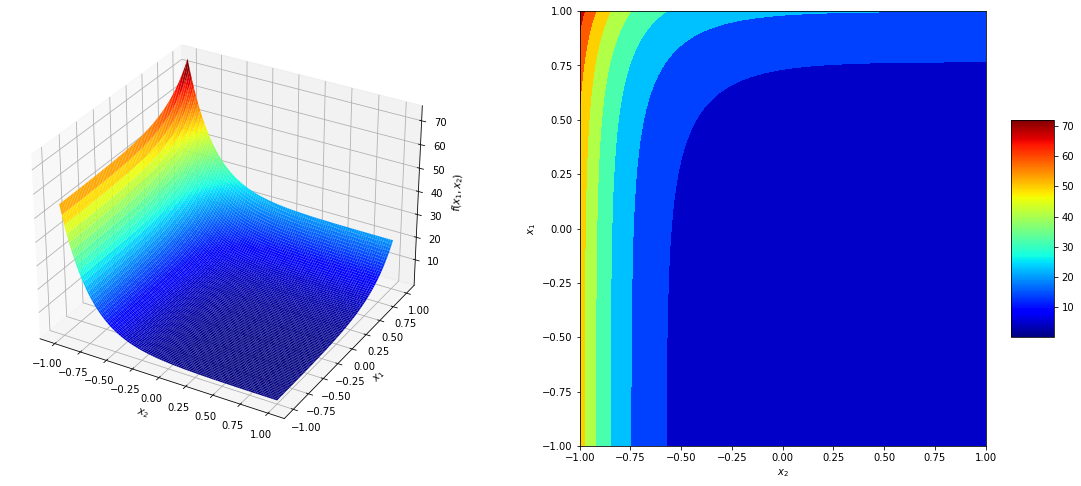

In [4]:
plot_function_surface(f, x_1_range=(-1, 1), x_2_range=(-1, 1))

In [5]:
def construct_linear_system(x, lamb):
    leq_matrix = np.zeros((3, 3))
    
    der_h = grad_h(x)
    
    leq_matrix[:-1, :-1] = hessian_laplacian(x, lamb)
    leq_matrix[-1, :-1] = -der_h
    leq_matrix[:-1, -1] = -der_h
    
    rh_vector = np.zeros(3)
    
    rh_vector[:-1] = -grad_laplacian(x, lamb)
    rh_vector[-1] = h(x)
    
    return leq_matrix, rh_vector

In [6]:
def qop(x_0, lamb_0, alpha=1, epsilon=1e-5):
    x = np.copy(x_0)
    lamb = lamb_0
    
    x_path = [x]
    lamb_path = [lamb]
    
    while np.linalg.norm(grad_laplacian(x, lamb)) >= epsilon:
        leq_matrix, rh_vector = construct_linear_system(x, lamb)
        
        v_dir = np.linalg.solve(leq_matrix, rh_vector)
        
        x += alpha * v_dir[:-1]
        lamb += alpha * v_dir[-1]
        
        x_path.append(x)
        lamb_path.append(lamb)
    
    return x, lamb, x_path, lamb_path

### Exercise 1

Let's check if we can get the given solution to this problem.

$$x_1^*, x_2^* = (-0.74834, 0.66332)^T$$
$$\lambda^* = -0.21233$$

In [7]:
x = np.array([-1., 1.])
lamb = -1

In [8]:
x_end, lamb_end, _, _ = qop(x, lamb)

print(x_end, lamb_end)

[-0.74833818  0.66332345] -0.21232390186241443


Success!  👍

### Exercise 2

In [9]:
x_list = np.array([[1., -1.], [0., -1.], [0., -0.75], [0.75, -0.5], [0.9, -0.8]])
lamb_list = [-1, -0.21232390186241443, 2]

for x_0 in x_list:
    for lamb_0 in lamb_list:
        x_end, lamb_end, _, _ = qop(x_0, lamb_0)
        print(x_end, lamb_end)

[ 0.91041323 -0.41370007] 25.293855202685933
[ 0.91041323 -0.41370007] 25.29385520271043
[ 0.91041323 -0.41370007] 25.293855202777692
[ 0.01434523 -0.9998971 ] 109.16259801290026
[ 0.01434523 -0.9998971 ] 109.16259756189065
[-0.74833549  0.66332044] -0.21232493446893563
[ 0.01434523 -0.9998971 ] 109.1625976096965
[ 0.01434522 -0.99989712] 109.1626012724059
[-0.74833589  0.6633201 ] -0.21232469031790208
[ 0.91041323 -0.41370006] 25.29385520417346
[ 0.91041323 -0.41370006] 25.29385520417471
[ 0.91041323 -0.41370006] 25.29385520417786
[ 0.91041323 -0.41370007] 25.293855187987205
[ 0.91041323 -0.41370007] 25.293855188679427
[ 0.91041323 -0.41370007] 25.29385519050294


There's no solution for $x_1, x_2 = (0, 0)$ because the linear system cannot be solved at that point (it's a singular matrix).

### Exercise 3

In [10]:
def merit(x, rho=10):
    return f(x) + rho * h(x)


def grad_merit(x, rho=10):
    return grad_f(x) + 2 * rho * h(x) * grad_h(x)

In [27]:
def gradient_descent(x_0, g, grad_g, rho=10, tol=1e-5, normalize=False):
    x = x_0
    x_path = [x]
    alpha = 0.001
    
    while np.linalg.norm(grad_g(x, rho)) >= tol:        
        grad_g_val = grad_g(x, rho)
        
        if normalize:
            grad_g_val /= np.linalg.norm(grad_g_val)
        
        x = x - alpha * grad_g_val
        x_path.append(x)
    
    return x, x_path

The normalization of the gradient made it really hard to converge to a value near the optimal. Therefore, we haven't applied it.

In [30]:
for x_0 in x_list:
    x_end, path = gradient_descent(x_0, merit, grad_merit)
    print(x_end)

[-0.75242478  0.66654823]
[-0.7524339   0.66653795]
[-0.7524339   0.66653796]
[-0.75242477  0.66654823]
[-0.75242478  0.66654823]


In [33]:
def qop_merit(x_0, lamb_0, g, grad_g, rho=10, tol=1e-5, normalize=False):
    x, x_path_merit = gradient_descent(x_0, g, grad_g, rho, tol, normalize)
    x, lamb, x_path_qop, lamb_path = qop(x, lamb_0, epsilon=tol)
    
    return x, lamb, x_path_merit, x_path_qop, lamb_path

In [34]:
for x_0 in x_list:
    for lamb_0 in lamb_list:
        x_end, lamb_end, _, _, _ = qop_merit(x_0, lamb_0, merit, grad_merit)
        print(x_end, lamb_end)

[-0.74833606  0.66331981] -0.21232500268673524
[-0.74833549  0.66332043] -0.21232493501483163
[-0.74833549  0.66332043] -0.21232493550295337
[-0.74833608  0.66331978] -0.21232500215661493
[-0.74833549  0.66332043] -0.21232493501505165
[-0.74833549  0.66332043] -0.21232493549853332
[-0.74833608  0.66331978] -0.21232500215678607
[-0.74833549  0.66332043] -0.21232493501505167
[-0.74833549  0.66332043] -0.2123249354985347
[-0.74833606  0.66331981] -0.21232500268693585
[-0.74833549  0.66332043] -0.21232493501483155
[-0.74833549  0.66332043] -0.2123249355029551
[-0.74833606  0.66331981] -0.21232500268676438
[-0.74833549  0.66332043] -0.21232493501483166
[-0.74833549  0.66332043] -0.21232493550295356


Overall, the solutions resemble the original.